<font size="5" color="blue"><b>Análisis del Dataset Enron-Spam mediante Técnicas de Machine Learning y PNL</b></font>

En este apartado se presenta el análisis del dataset Enron-Spam, el cual contiene correos electrónicos clasificados como spam y ham (no spam). Dicho conjunto de datos se encuentra disponible en la siguiente dirección: Khttps://www.kaggle.com/datasets/marcelwiechmann/enron-spam-data
.

<font size="4" color="deepskyblue"><b>Fase 1</b></font>

En esta primera fase se realiza la importación de las librerías para el análisis, así como una exploración inicial del dataset Enron-Spam. El objetivo es conocer la estructura de los datos y preparar el entorno de trabajo para aplicar las técnicas de Machine Learning en fases posteriores.

In [26]:
# Fase I: Importación de librerías y carga de datos
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub  # Para descargar datasets de Kaggle
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, ConfusionMatrixDisplay
)

<font size="4" color="deepskyblue"><b>Fase 2</b></font>

 Descargar el dataset de Enrom y checar los primeros 5 datos del dataset y checar mediante un histograma de frecuencia los correos de Spam y correos de no spam

In [27]:
# Descargar la ultima version de los datos
import kagglehub # Import kagglehub
import os # Import os to join paths

path = kagglehub.dataset_download("marcelwiechmann/enron-spam-data")
csv_path = os.path.join(path, "enron_spam_data.csv")

# Lear the CSV file
df = pd.read_csv(csv_path)
# Checar los primeros 5 datos
print(df.head())

Using Colab cache for faster access to the 'enron-spam-data' dataset.
   Unnamed: 0                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  


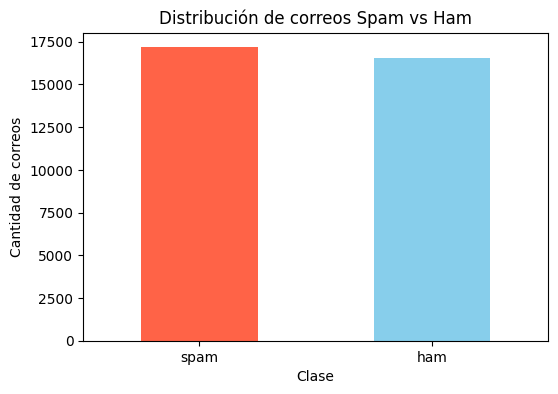

In [28]:
class_counts = df["Spam/Ham"].value_counts()  # Ver distribución de clases,

# Total de correos = 33,716 donde hay 17,171 correos de spam y 16,545 de no espam
# Gráfico de frecuencia de los correos
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["tomato", "skyblue"])  # Colores diferentes para cada clase
plt.title("Distribución de correos Spam vs Ham")
plt.xlabel("Clase")
plt.ylabel("Cantidad de correos")
plt.xticks(rotation=0)  # Mantener etiquetas horizontales
plt.show()

<font size="4" color="deepskyblue"><b>Fase 3</b></font>

 Limpieza del texto o preprocesamiento del texto es necesario para eliminar elementos irrelevantes que pueden afectar el rendimiento del modelo de PNL

In [29]:

#3. Limpiar texto

import re  # Librería de expresiones regulares (para buscar y reemplazar patrones en el texto)

# Función para limpiar el texto de los correos
def clean_text(text):
    # Si el valor es NaN (faltante), devolver un string vacío
    if pd.isna(text):
        return ""
    # Convertir todo el texto a minúsculas
    text = text.lower()
    # Eliminar URLs (ej. http://example.com)
    text = re.sub(r"http\S+", " ", text)
    # Eliminar números
    text = re.sub(r"\d+", " ", text)
    # Eliminar signos de puntuación y caracteres especiales (solo dejar letras y espacios)
    text = re.sub(r"[^\w\s]", " ", text)
    return text  # Devolver el texto limpio

# Crear nueva columna "text" uniendo el Subject y Message (si hay NaN se reemplaza con "")
# Luego se aplica la función de limpieza definida arriba
df["text"] = (df["Subject"].fillna("") + " " + df["Message"].fillna("")).apply(clean_text)

# Normalizar etiquetas: convertir columna "Spam/Ham" a minúsculas y guardarla como "label"
df["label"] = df["Spam/Ham"].str.lower()

# 3. Vectorización con TF-IDF


# Inicializar el vectorizador TF-IDF
# - stop_words="english": elimina palabras vacías comunes en inglés (ej. "the", "and", "is")
# - max_features=5000: se limita a las 5000 palabras más relevantes
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

# Transformar el texto en una matriz numérica (X = características, y = etiquetas)
X = vectorizer.fit_transform(df["text"])  # Matriz TF-IDF del texto
y = df["label"]  # Variable objetivo (spam o ham)


<font size="4" color="deepskyblue"><b>Fase 4</b></font>

División de los 33,716 correos en  70% Entrenamiento, 15% Validación, 15% Prueba

In [30]:
# Train (70%) y Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# De Temp (30%), la mitad será validación (15%) y la otra mitad prueba (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)
# Mostrar el tamaño de los conjuntos
print("\nTamaños de los conjuntos:")
print("Entrenamiento:", X_train.shape[0])
print("Validación:", X_val.shape[0])
print("Prueba:", X_test.shape[0])



Tamaños de los conjuntos:
Entrenamiento: 23601
Validación: 5057
Prueba: 5058


<font size="4" color="deepskyblue"><b>Fase 5</b></font>

Modelo de Machine Learning de clasificación


<font size="3" color="deepskyblue"><b>Modelo de Regresión Lógistica</b></font>


La fórmula de la regresión logística es:

P(spam | x) = 1 / (1 + e^-(b0 + b1*x1 + b2*x2 + ... + bn*xn))

Donde:

- b0 = intercepto
- bi = coeficientes asociados a cada palabra
- xi = valor TF-IDF de la palabra i en el correo a clasificar

El modelo predice spam si P > 0.5

In [31]:
# Modelo
log_model = LogisticRegression(max_iter=1000, solver="liblinear")
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

# <font size="4" color="deepskyblue"><b>Fase 6</b></font>

Métricas de Validación del modelo de regresión Logistica

In [32]:
y_val_pred = log_model.predict(X_val)
print("\n--- Métricas en VALIDACIÓN ---")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred, pos_label="spam"))
print("Precision:", precision_score(y_val, y_val_pred, pos_label="spam"))
print("F1-score:", f1_score(y_val, y_val_pred, pos_label="spam"))


--- Métricas en VALIDACIÓN ---
Accuracy: 0.9988135258058137
Recall: 1.0
Precision: 0.997675319643549
F1-score: 0.9988363072148952


Métricas en prueba

In [33]:
# -------- Prueba --------
y_test_pred = log_model.predict(X_test)
print("\n--- Métricas en PRUEBA ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred, pos_label="spam"))
print("Precision:", precision_score(y_test, y_test_pred, pos_label="spam"))
print("F1-score:", f1_score(y_test, y_test_pred, pos_label="spam"))


--- Métricas en PRUEBA ---
Accuracy: 0.9996045867931989
Recall: 1.0
Precision: 0.9992242048099301
F1-score: 0.9996119518820333


In [34]:
# -------- Tabla Comparativa --------
results_df = pd.DataFrame([val_metrics, test_metrics], index=["Validación", "Prueba"])
print("\n=== Comparación de Métricas ===")
print(results_df)


=== Comparación de Métricas ===
            Accuracy  Recall  Precision  F1-score
Validación  0.998814     1.0   0.997675  0.998836
Prueba      0.999605     1.0   0.999224  0.999612


Como conclusion el modelo no dejó pasar ningún correo spam como ham, lo cual es crítico en sistemas de ciberseguridad  

Accuracy: 0.9988 (~99.88%): El modelo acierta en casi el 99.9% de los correos de validación (spam y ham

***Recall:*** 1.0 (100%): El modelo detectó todos los correos spam correctamente (no dejó escapar ninguno)

***Precision:*** 0.9977 (~99.77%): De todos los correos que el modelo predijo como spam, el 99.77% realmente eran spam.
Muy pocas veces etiqueta como spam a un correo que en realidad era ham (falsos positivos).

F1-score: 0.9988 (~99.88%):Es un balance entre precision y recall.

<font size="4" color="deepskyblue"><b>Fase 7</b></font>

Matriz de confusión

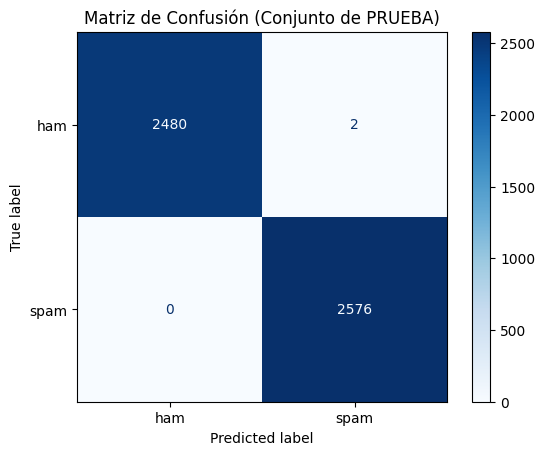

In [35]:
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión (Conjunto de PRUEBA)")
plt.show()